In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../src')
import numpy as np
import matplotlib.pyplot as plt
from simulation.simulation import *

In [2]:
parameters = {
    "n_of_replicas" : 5,
    "n_humans" : 1000,
    "n_bots" : 10,
    "nei" : 6,
    "p" : 0.05,
    "N_steps" : 500,
    "waiting_time" : 208,
    "mu" : 0.075,
    "epsilon": 0.3,
    "bot_threshold" : -0.5,
    "beta0" : 0.0125,
    "recovery_rate" : 0.025,
    "I0" : 1,
    "communication_error" : 0.1,
    "post_history": 10,
    "feed_size": 5
}
RES0 = simulations(parameters)
save_results(RES0, "only100_0bots_0noise.pkl")
# save the results

Running replica 1/5
Step 0 of 500


AttributeError: 'Graph' object has no attribute 'get'

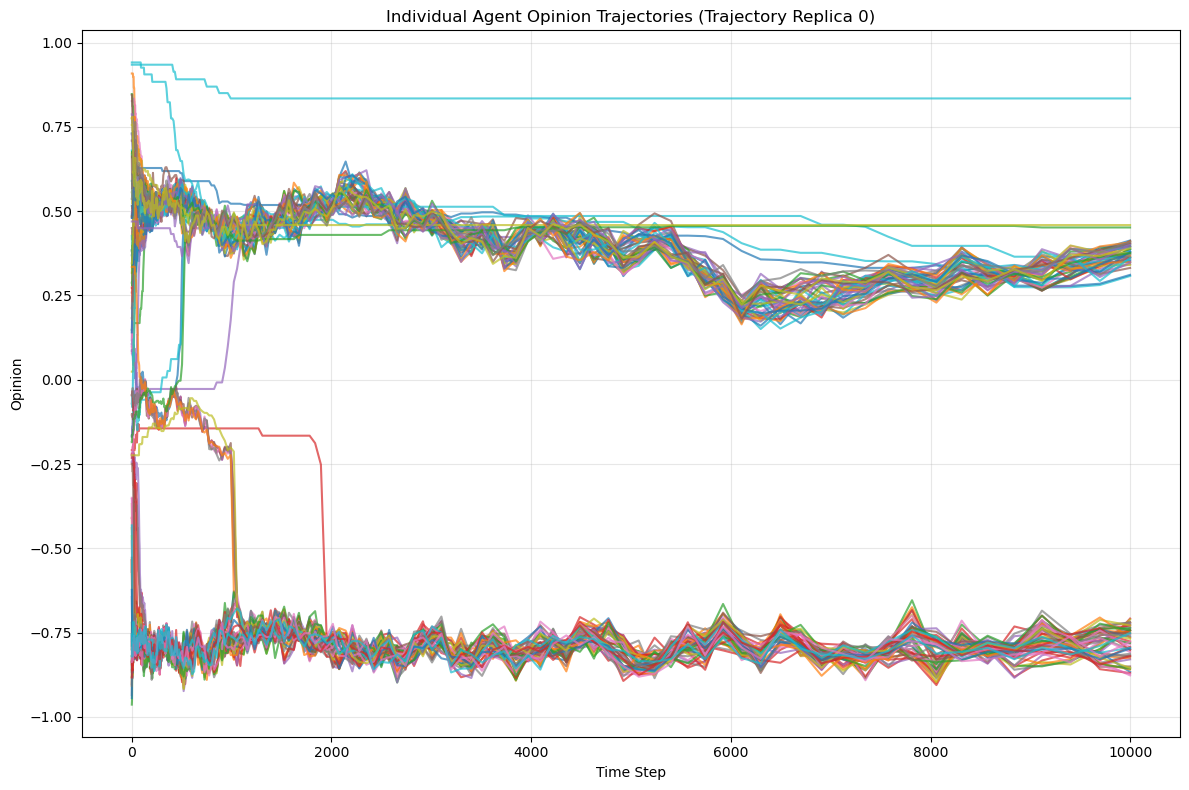

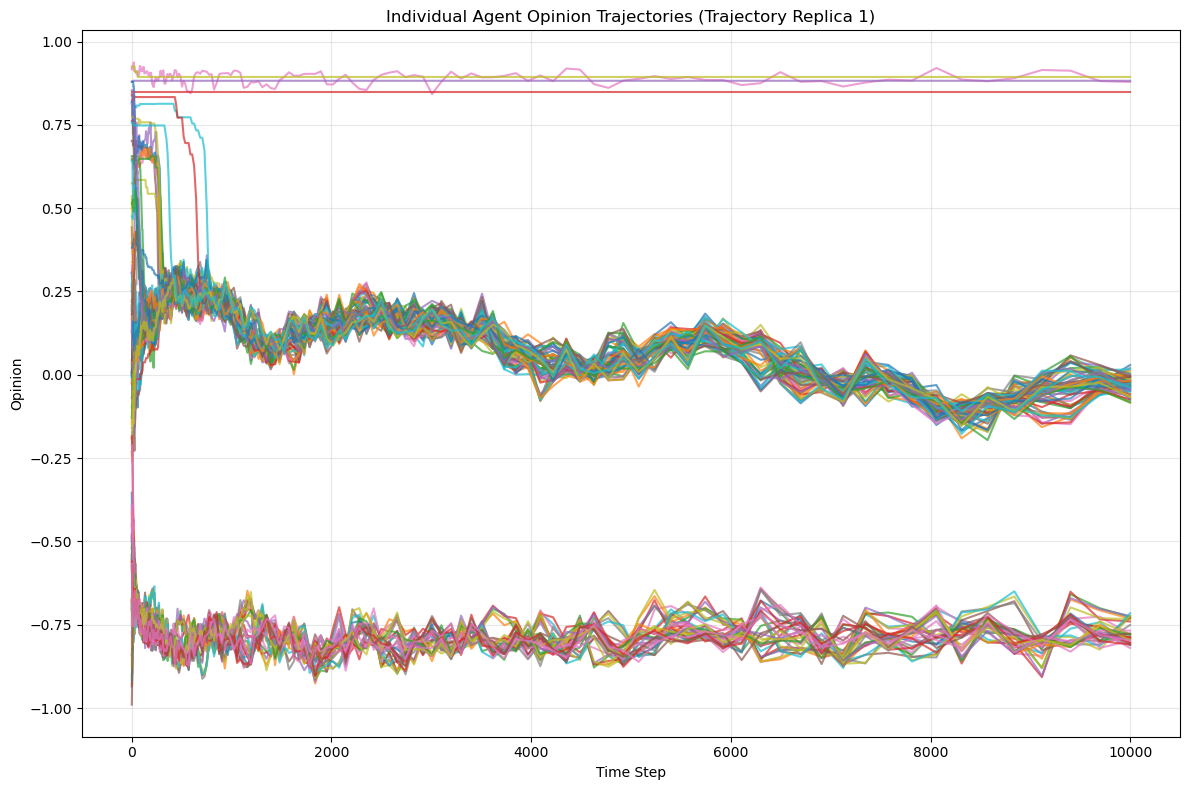

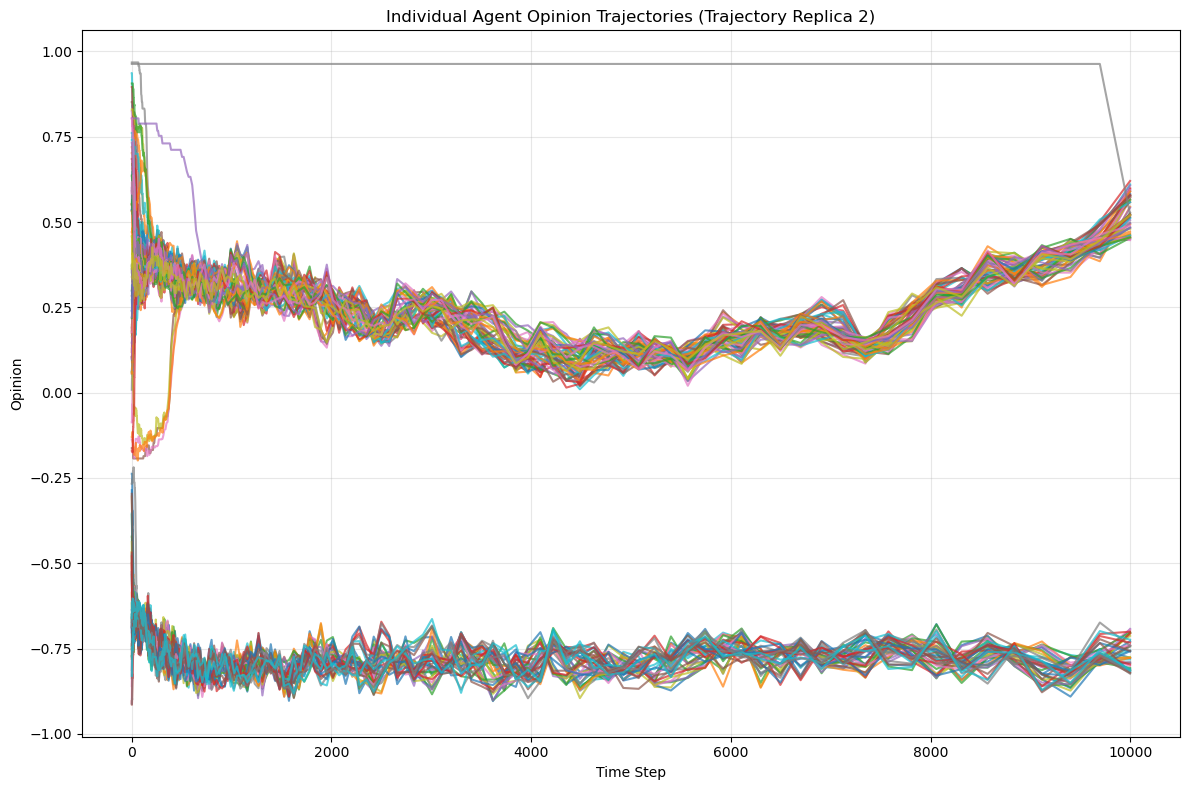

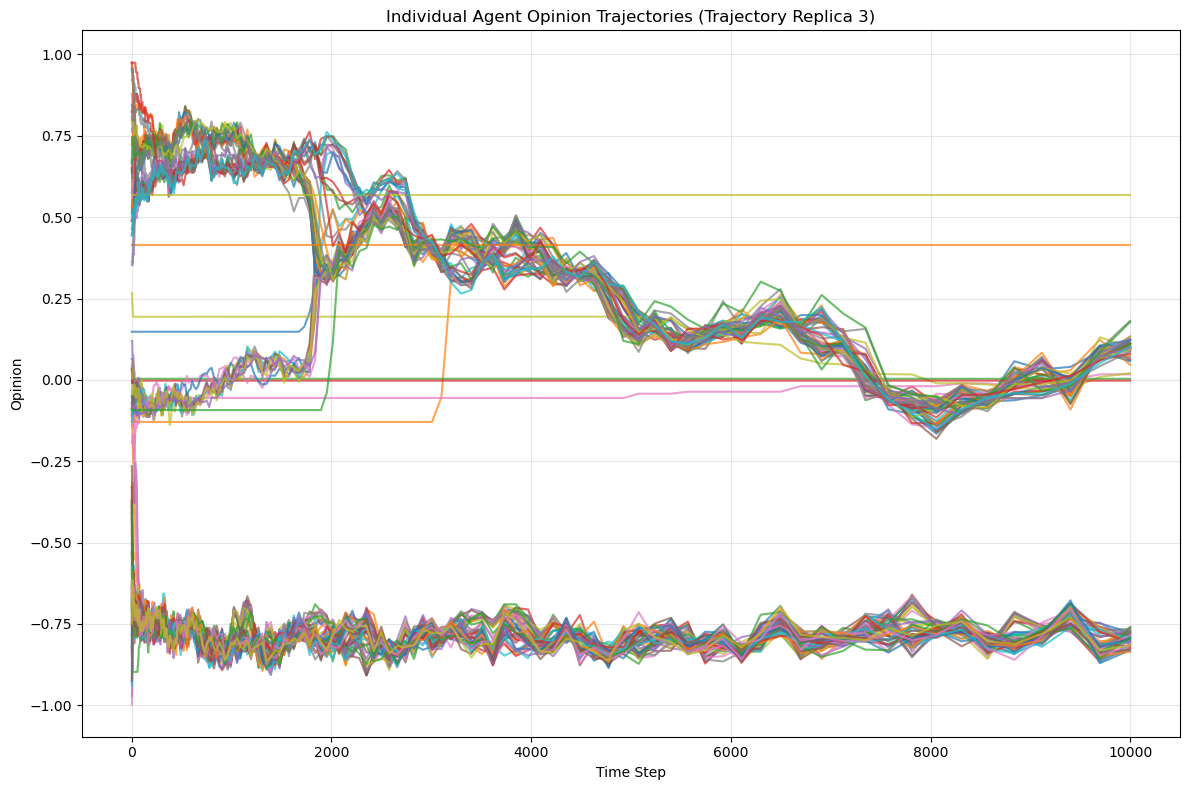

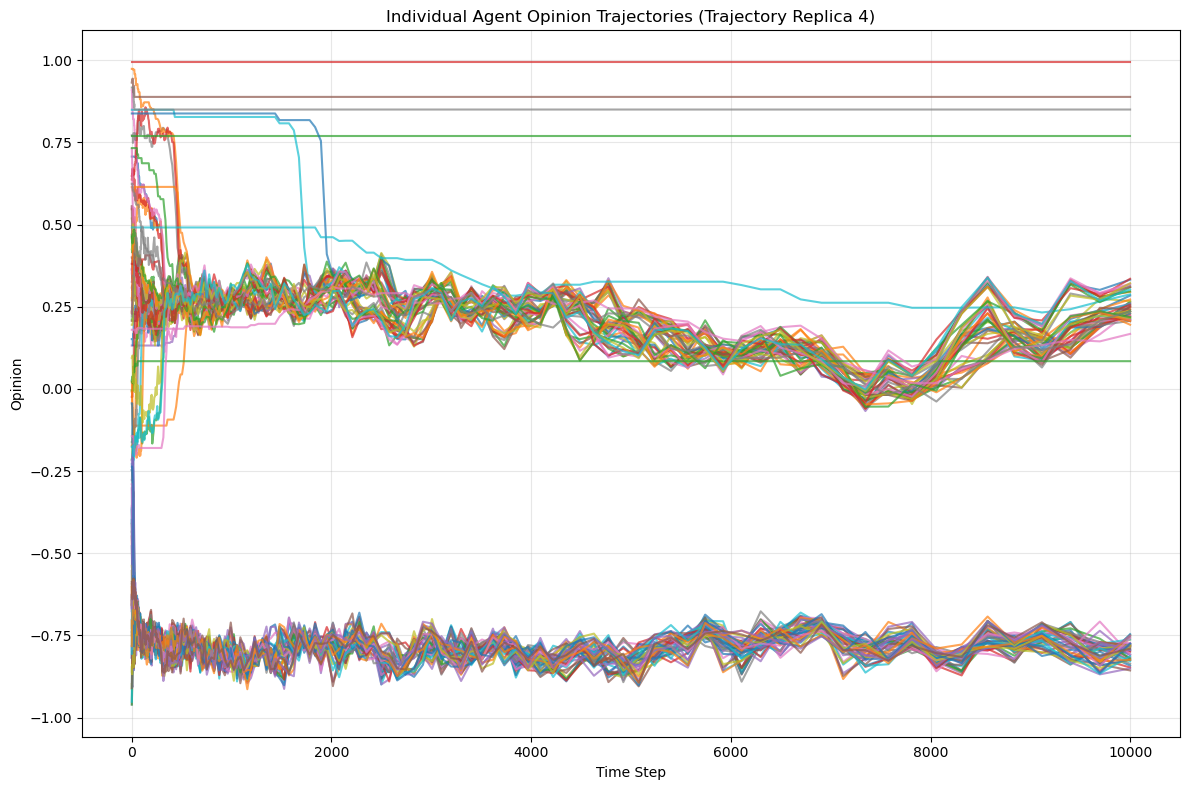

In [29]:
plot_agent_opinions(RES0, replica_idx=0, n_agents_to_plot=100)
plot_agent_opinions(RES0, replica_idx=1, n_agents_to_plot=100)
plot_agent_opinions(RES0, replica_idx=2, n_agents_to_plot=100)
plot_agent_opinions(RES0, replica_idx=3, n_agents_to_plot=100)
plot_agent_opinions(RES0, replica_idx=4, n_agents_to_plot=100)


In [10]:
def plot_agent_opinions(consolidated, replica_idx=0, n_agents_to_plot=10):
    """
    Plot opinion trajectories for individual agents over time
    
    Args:
        consolidated: Consolidated results from simulations()
        replica_idx: Which trajectory replica to plot (default: first one)
        n_agents_to_plot: How many agents to show (default: 10)
    """
    # Check if trajectory data exists
    if consolidated['opinions'] is None:
        print("No trajectory data available. Only first 5 replicas have individual opinion trajectories.")
        return
    
    # Check if requested replica has trajectory data
    if replica_idx >= consolidated['opinions'].shape[0]:
        print(f"Replica {replica_idx} doesn't have trajectory data.")
        print(f"Available trajectory replicas: 0 to {consolidated['opinions'].shape[0]-1}")
        return
    
    # Get data from specified replica
    save_steps = consolidated['save_steps']  # Time points when opinions were saved
    opinions = consolidated['opinions'][replica_idx]  # Shape: (n_time_points, n_humans)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot trajectories for first n_agents_to_plot agents
    for agent_id in range(min(n_agents_to_plot, opinions.shape[1])):
        agent_opinions = opinions[:, agent_id]  # Opinion trajectory for this agent
        plt.plot(save_steps, agent_opinions, alpha=0.7, linewidth=1.5, 
                label=f'Agent {agent_id}' if n_agents_to_plot <= 10 else None)
    
    plt.xlabel('Time Step')
    plt.ylabel('Opinion')
    plt.title(f'Individual Agent Opinion Trajectories (Trajectory Replica {replica_idx})')
    plt.grid(True, alpha=0.3)
    
    # Add legend only if not too many agents
    if n_agents_to_plot <= 10:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

def plot_opinion_distribution_evolution(consolidated, replica_idx=None):
    """
    Plot how opinion distribution changes over time using binned data
    
    Args:
        consolidated: Consolidated results from simulations()
        replica_idx: Which replica to plot (None for average across all replicas)
    """
    # Get opinion bins data
    if replica_idx is None:
        # Average across all replicas
        opinion_bins = np.mean(consolidated['opinion_bins'], axis=0)  # Shape: (n_steps, n_bins)
        title = "Opinion Distribution Evolution (Average across all replicas)"
    else:
        # Specific replica
        opinion_bins = consolidated['opinion_bins'][replica_idx]  # Shape: (n_steps, n_bins)
        title = f"Opinion Distribution Evolution (Replica {replica_idx})"
    
    # Create time points
    time_steps = np.arange(opinion_bins.shape[0])
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    
    # Create a heatmap
    im = plt.imshow(opinion_bins.T, aspect='auto', origin='lower', 
                    extent=[0, len(time_steps)-1, 0, len(consolidated['bin_labels'])-1],
                    cmap='viridis', interpolation='nearest')
    
    plt.colorbar(im, label='Fraction of Agents')
    plt.xlabel('Time Step')
    plt.ylabel('Opinion Bin')
    plt.title(title)
    
    # Set y-axis labels to show bin ranges
    bin_labels = consolidated['bin_labels']
    tick_positions = np.arange(len(bin_labels))
    plt.yticks(tick_positions, [f'{i}: {label}' for i, label in enumerate(bin_labels)], fontsize=8)
    
    plt.tight_layout()
    plt.show()

def plot_aggregate_statistics(consolidated):
    """
    Plot aggregate statistics across all replicas
    
    Args:
        consolidated: Consolidated results from simulations()
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Time steps
    time_steps = np.arange(consolidated['mean_opinion'].shape[1])
    
    # Plot 1: Mean opinion over time
    ax1 = axes[0, 0]
    mean_trajectory = np.mean(consolidated['mean_opinion'], axis=0)
    std_trajectory = np.std(consolidated['mean_opinion'], axis=0)
    
    ax1.plot(time_steps, mean_trajectory, 'b-', linewidth=2, label='Mean')
    ax1.fill_between(time_steps, 
                     mean_trajectory - std_trajectory,
                     mean_trajectory + std_trajectory, 
                     alpha=0.3, color='blue', label='±1 std')
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Mean Opinion')
    ax1.set_title('Mean Opinion Evolution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Opinion variance over time
    ax2 = axes[0, 1]
    var_mean = np.mean(consolidated['opinion_var'], axis=0)
    var_std = np.std(consolidated['opinion_var'], axis=0)
    
    ax2.plot(time_steps, var_mean, 'r-', linewidth=2, label='Mean')
    ax2.fill_between(time_steps, 
                     var_mean - var_std,
                     var_mean + var_std, 
                     alpha=0.3, color='red', label='±1 std')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Opinion Variance')
    ax2.set_title('Opinion Variance Evolution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Extreme opinions over time
    ax3 = axes[1, 0]
    # Very negative opinions (first bin: < -0.9)
    extreme_neg = np.mean(consolidated['opinion_bins'][:, :, 0], axis=0)
    # Very positive opinions (last bin: > 0.9)
    extreme_pos = np.mean(consolidated['opinion_bins'][:, :, -1], axis=0)
    
    ax3.plot(time_steps, extreme_neg, 'r-', linewidth=2, label='Very negative (<-0.9)')
    ax3.plot(time_steps, extreme_pos, 'b-', linewidth=2, label='Very positive (>0.9)')
    ax3.set_xlabel('Time Step')
    ax3.set_ylabel('Fraction of Agents')
    ax3.set_title('Extreme Opinion Evolution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Disease dynamics
    ax4 = axes[1, 1]
    I_mean = np.mean(consolidated['I_count'], axis=0)
    R_mean = np.mean(consolidated['R_count'], axis=0)
    
    ax4.plot(time_steps, I_mean, 'orange', linewidth=2, label='Infected')
    ax4.plot(time_steps, R_mean, 'green', linewidth=2, label='Recovered')
    ax4.set_xlabel('Time Step')
    ax4.set_ylabel('Number of Agents')
    ax4.set_title('Disease Dynamics')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

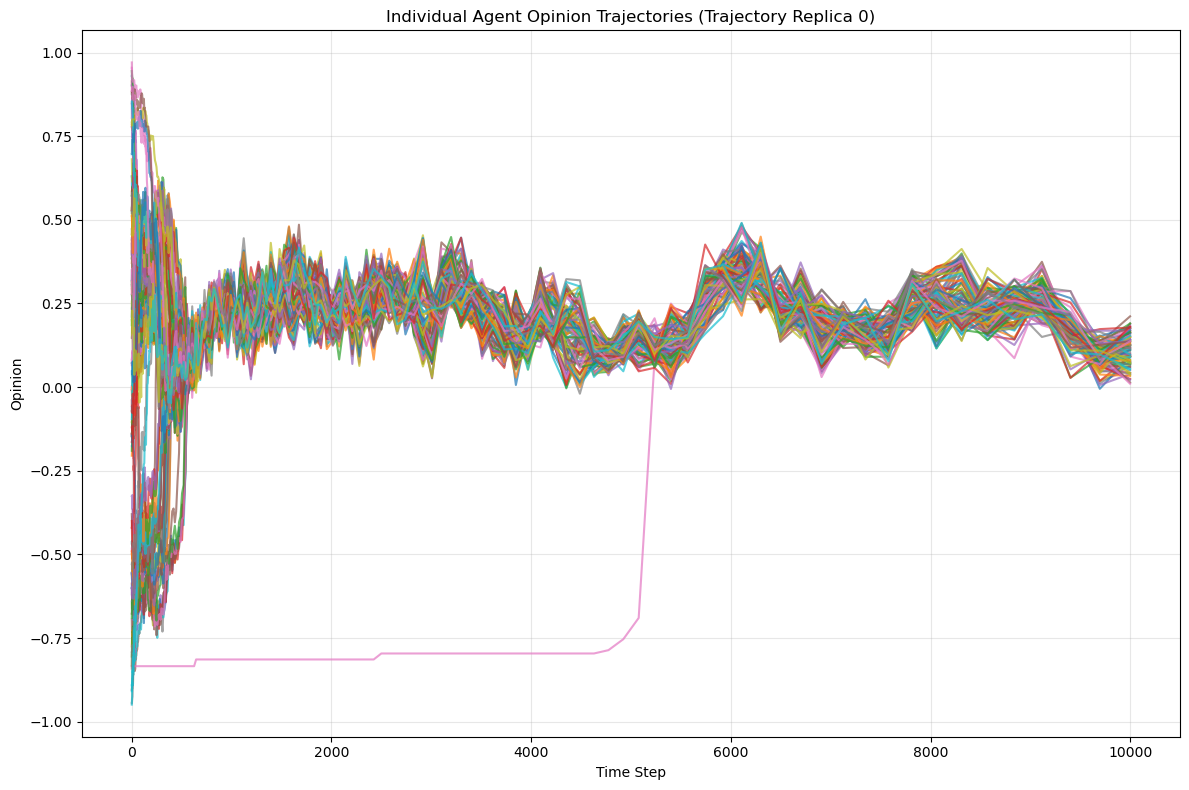

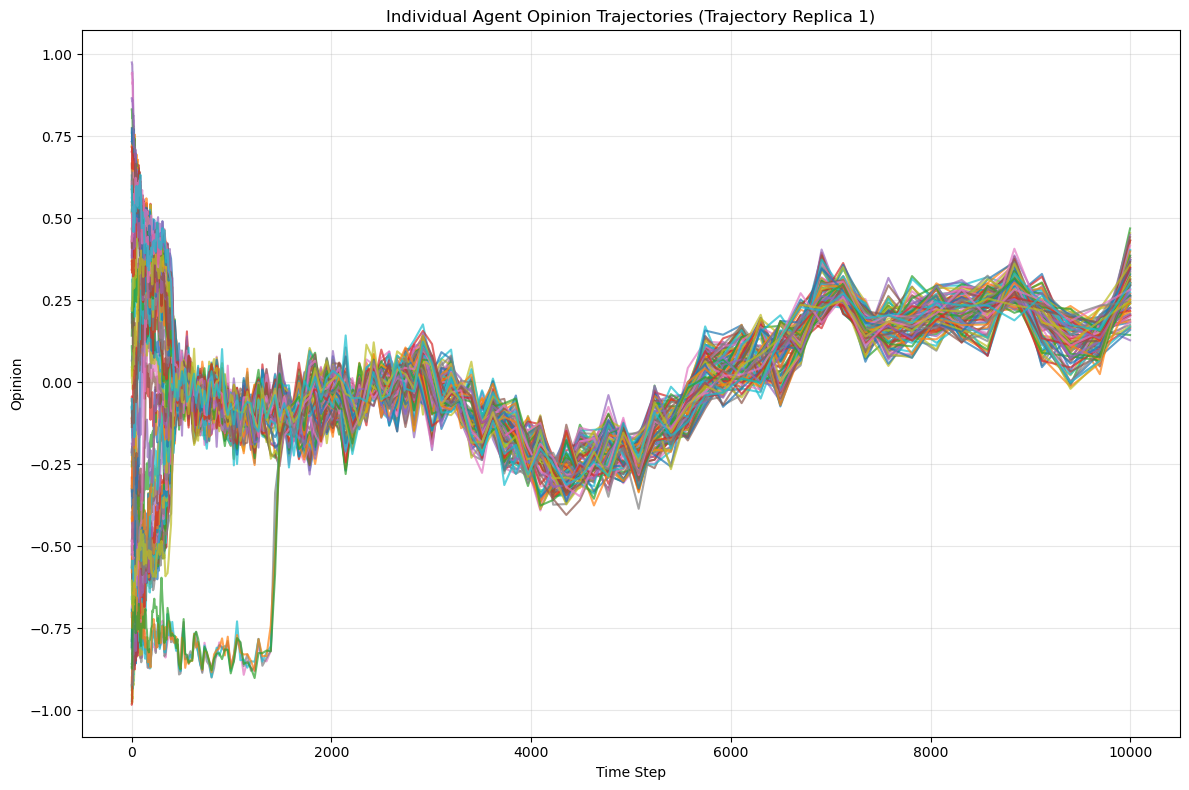

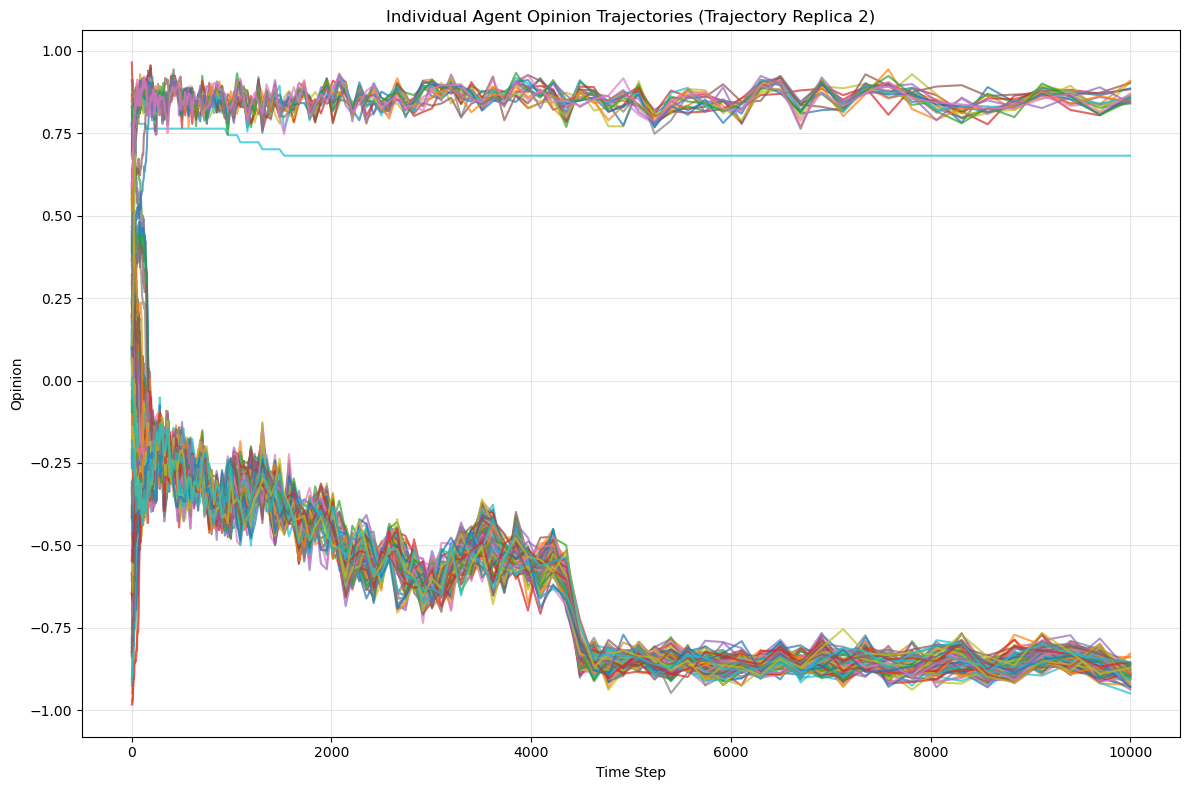

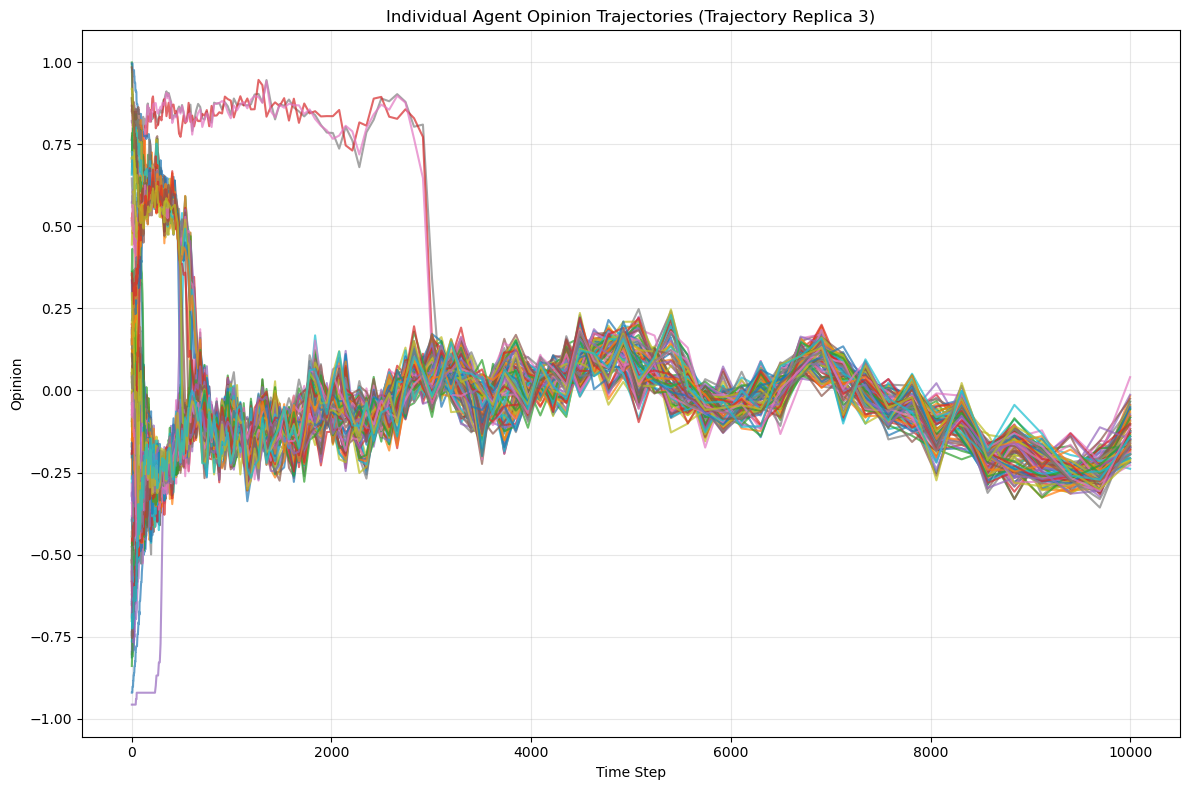

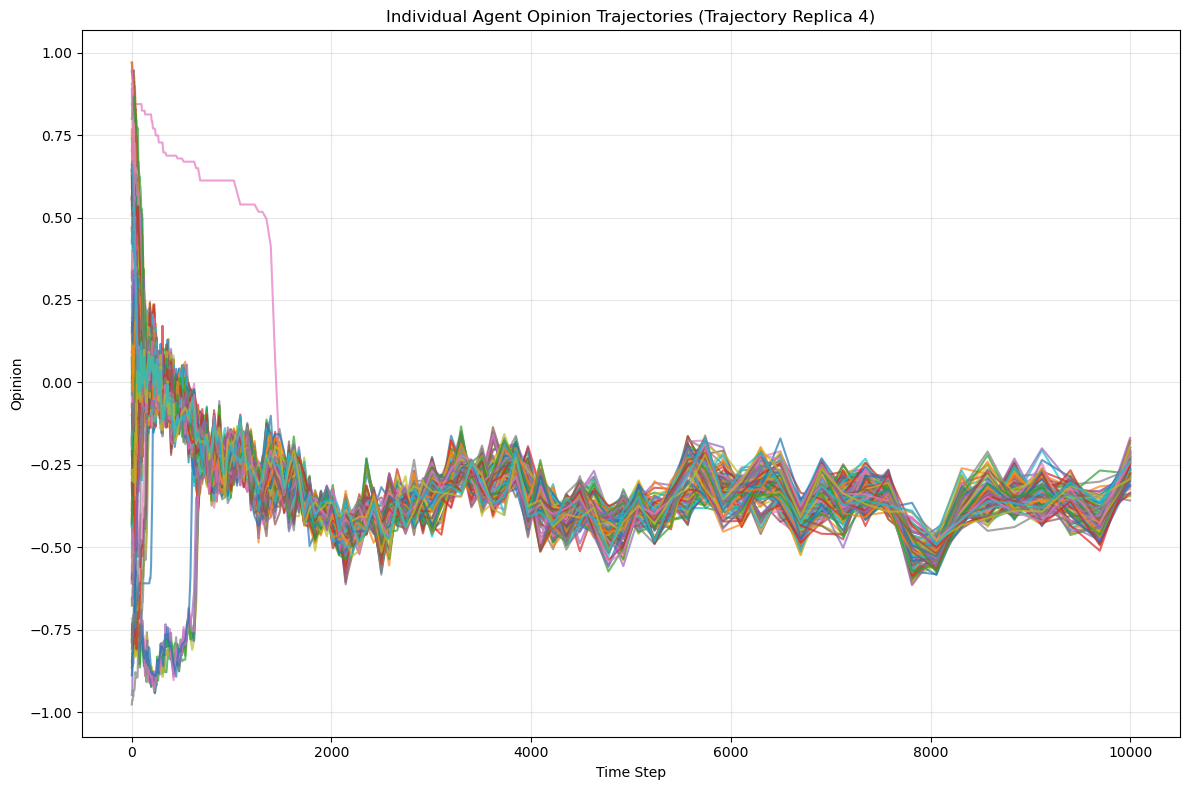

In [25]:
plot_agent_opinions(RES0, replica_idx=0, n_agents_to_plot=100)
plot_agent_opinions(RES0, replica_idx=1, n_agents_to_plot=100)
plot_agent_opinions(RES0, replica_idx=2, n_agents_to_plot=100)
plot_agent_opinions(RES0, replica_idx=3, n_agents_to_plot=100)
plot_agent_opinions(RES0, replica_idx=4, n_agents_to_plot=100)


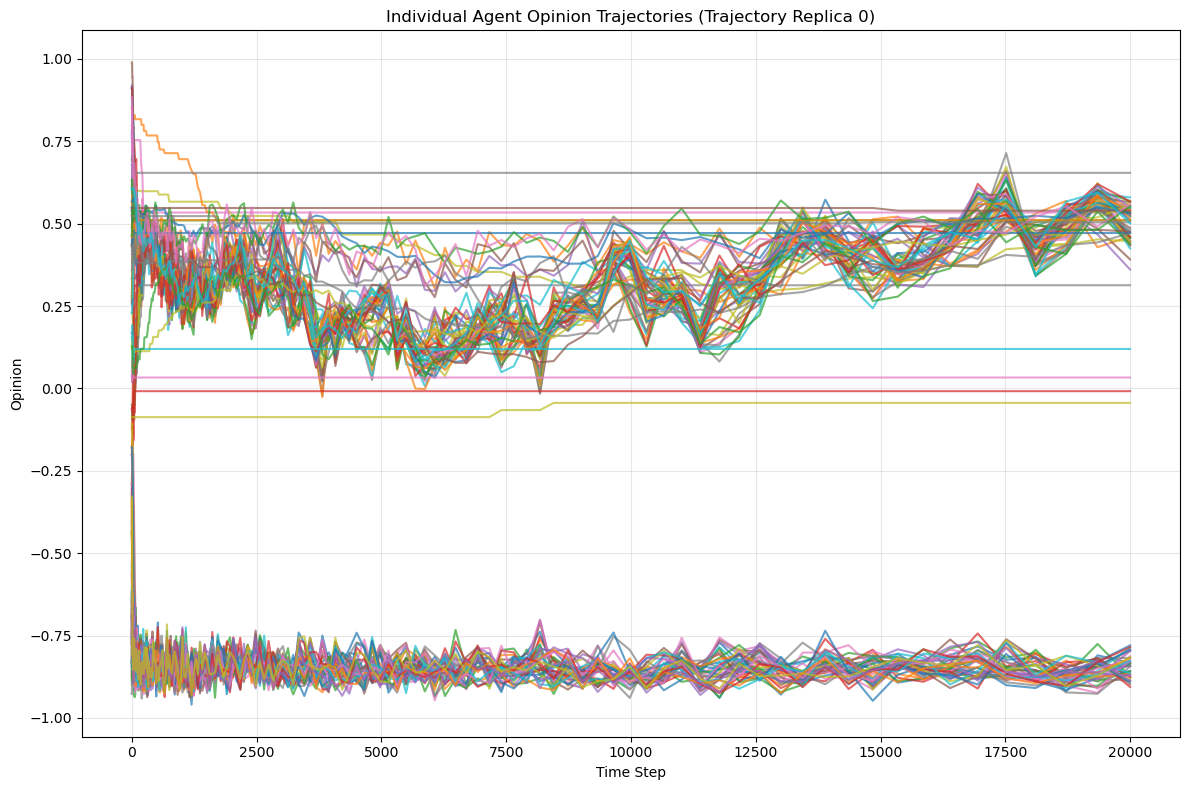

In [18]:
plot_agent_opinions(RES, replica_idx=0, n_agents_to_plot=100)

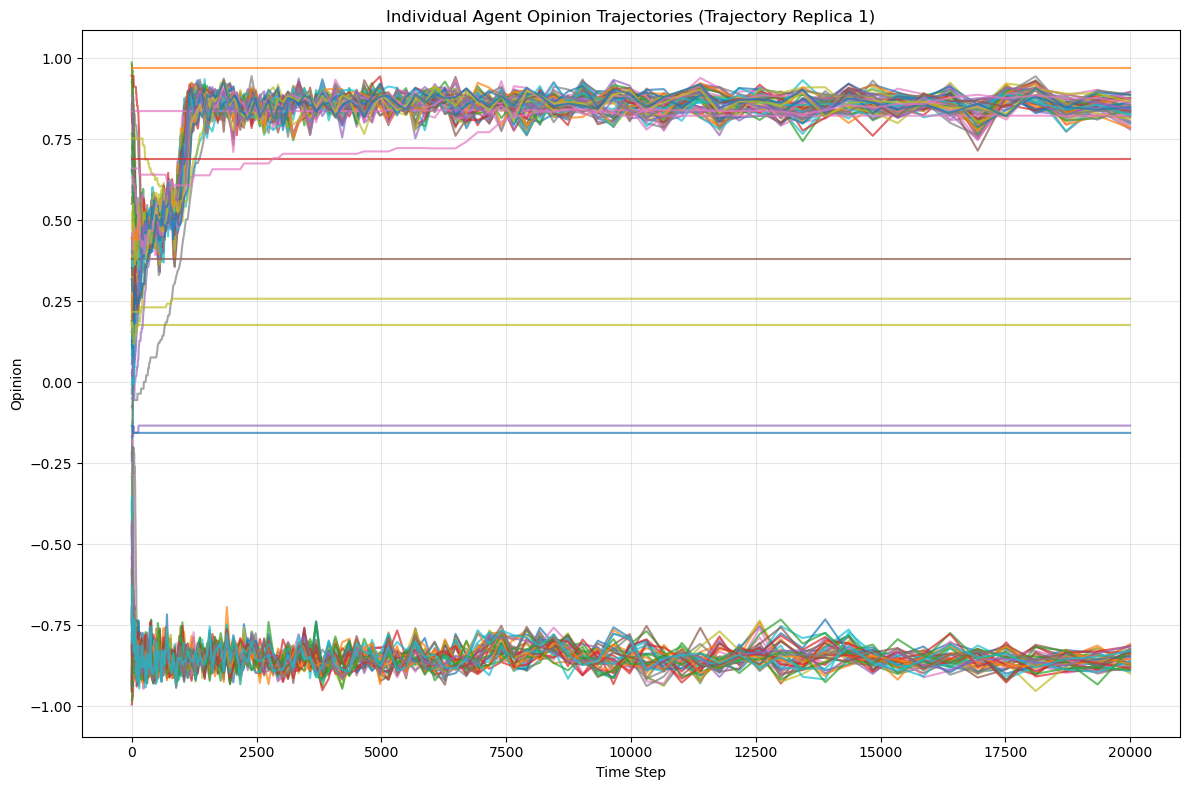

In [19]:
plot_agent_opinions(RES, replica_idx=1, n_agents_to_plot=100)

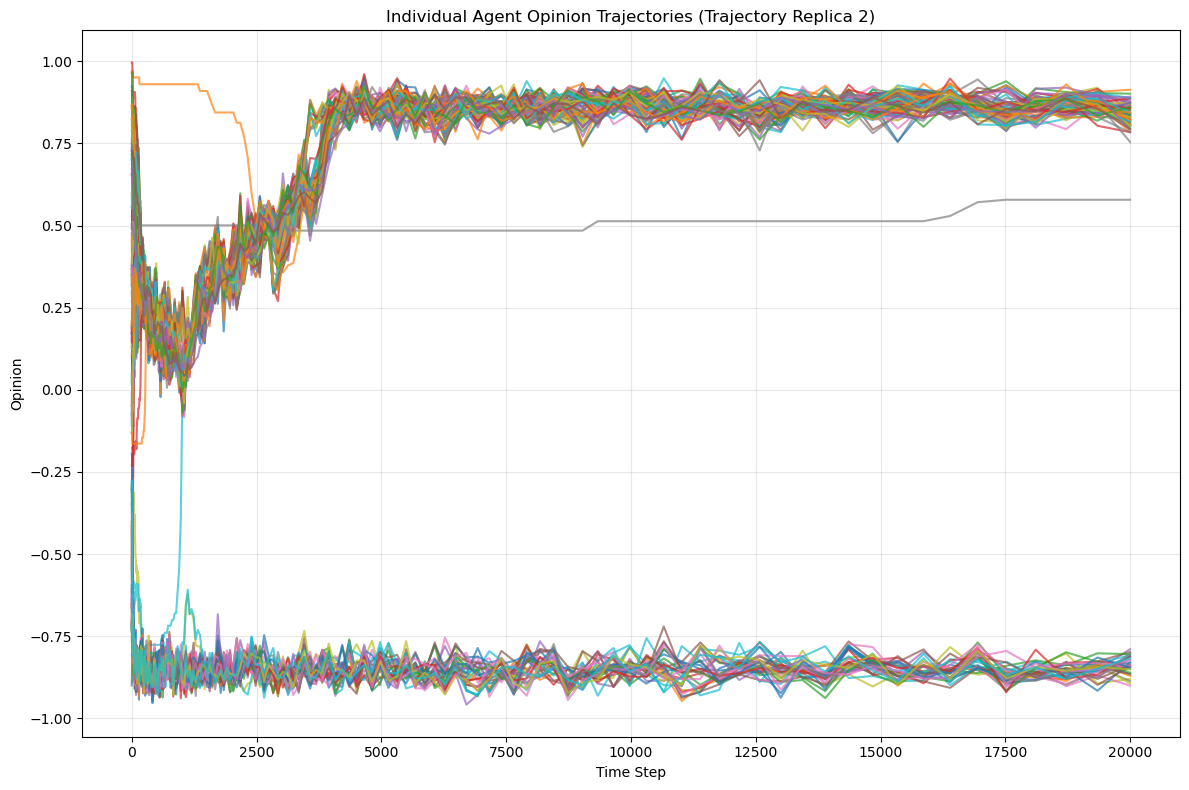

In [20]:
plot_agent_opinions(RES, replica_idx=2, n_agents_to_plot=100)

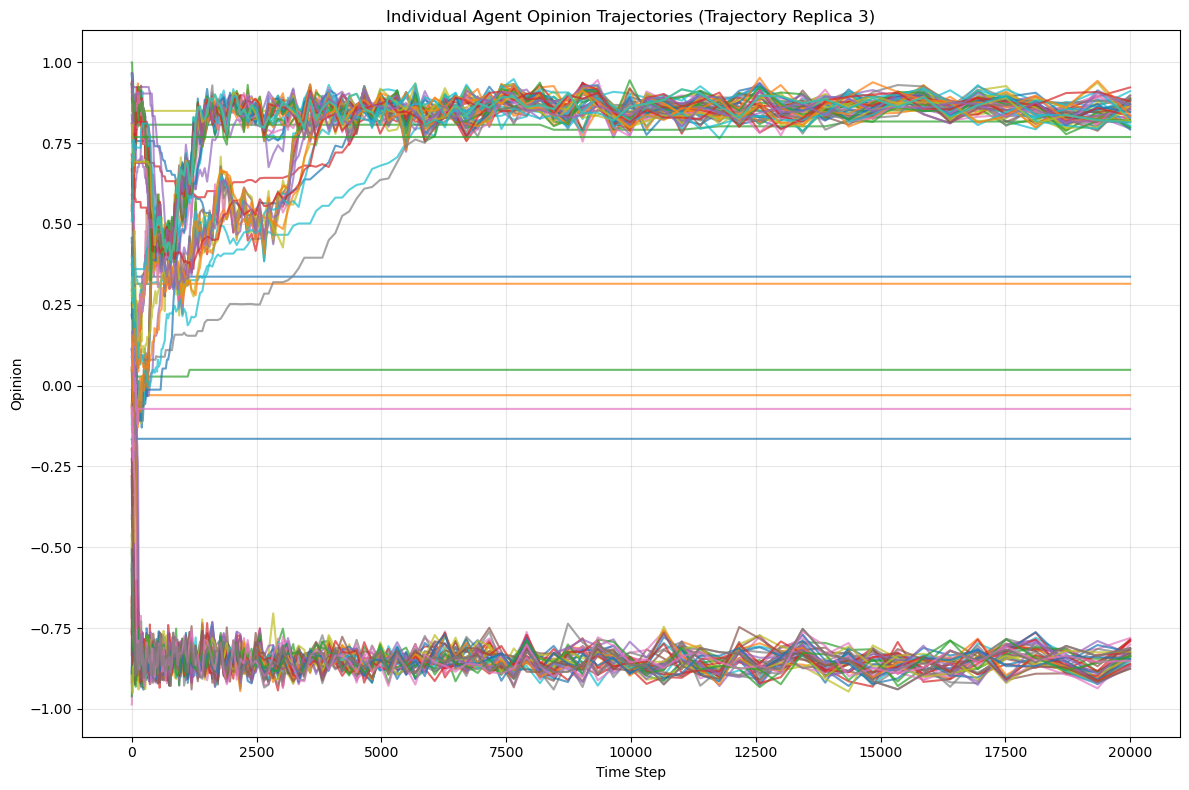

In [21]:
plot_agent_opinions(RES, replica_idx=3, n_agents_to_plot=100)

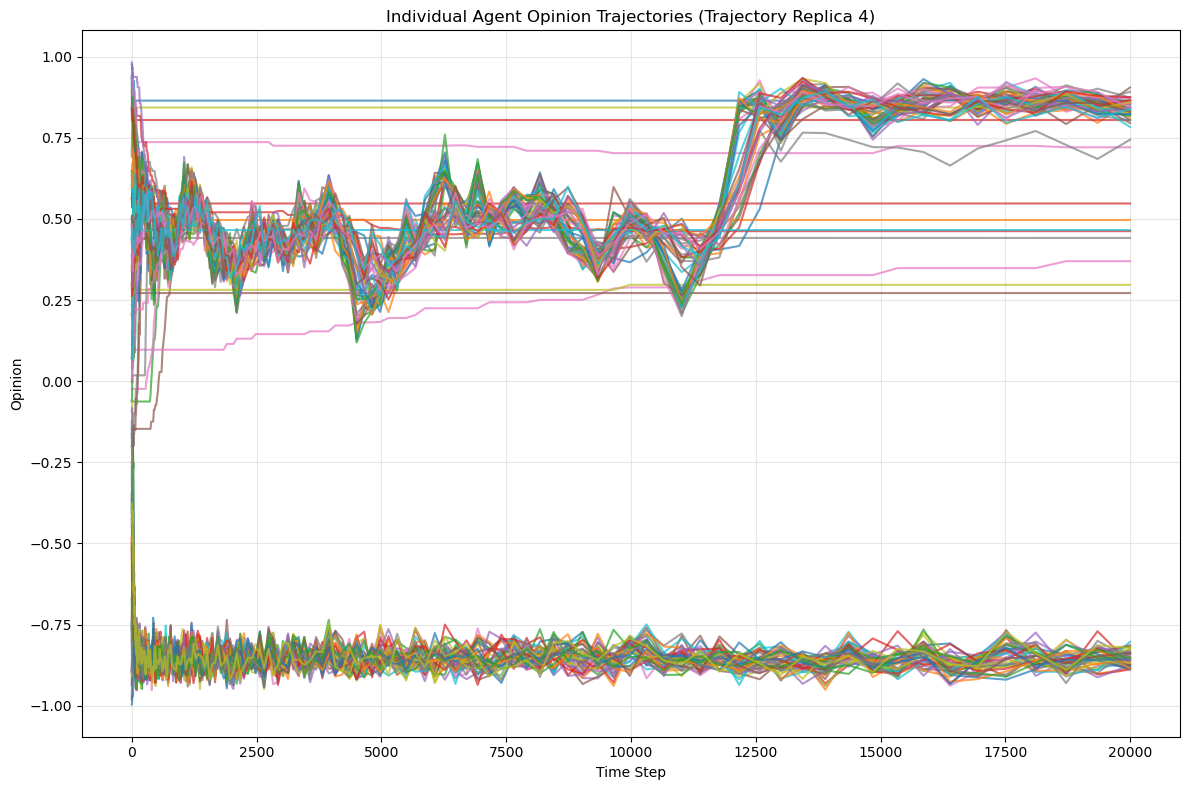

In [22]:
plot_agent_opinions(RES, replica_idx=4, n_agents_to_plot=100)

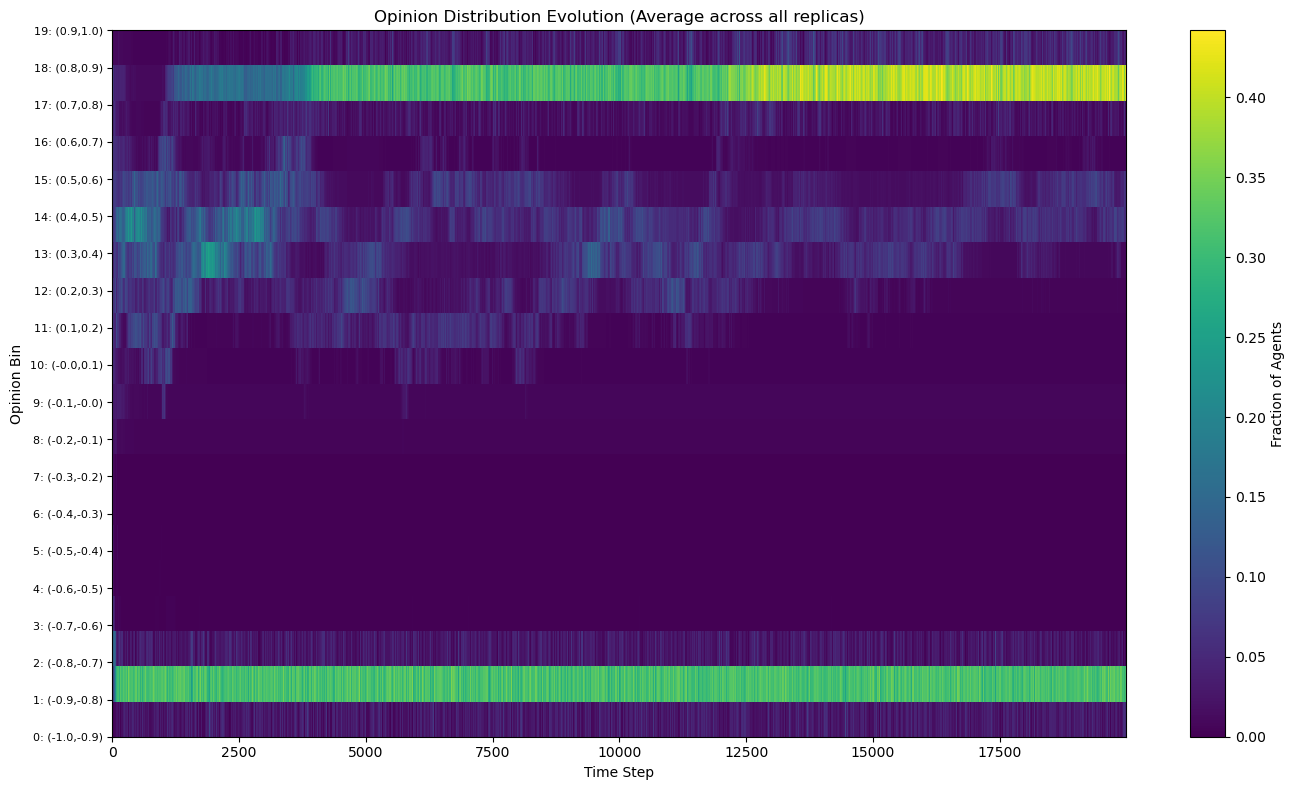

In [23]:
plot_opinion_distribution_evolution(RES)  # Specific replica

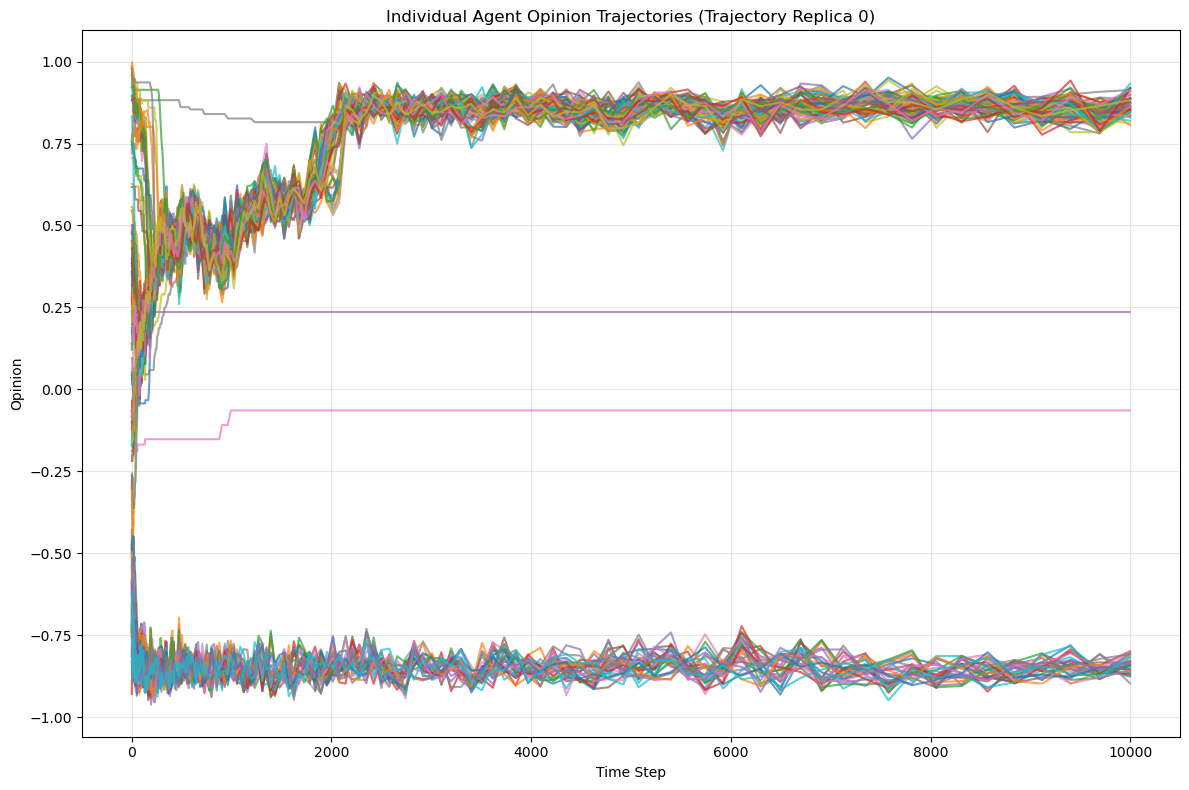

In [16]:
plot_agent_opinions(RES, replica_idx=0, n_agents_to_plot=100)

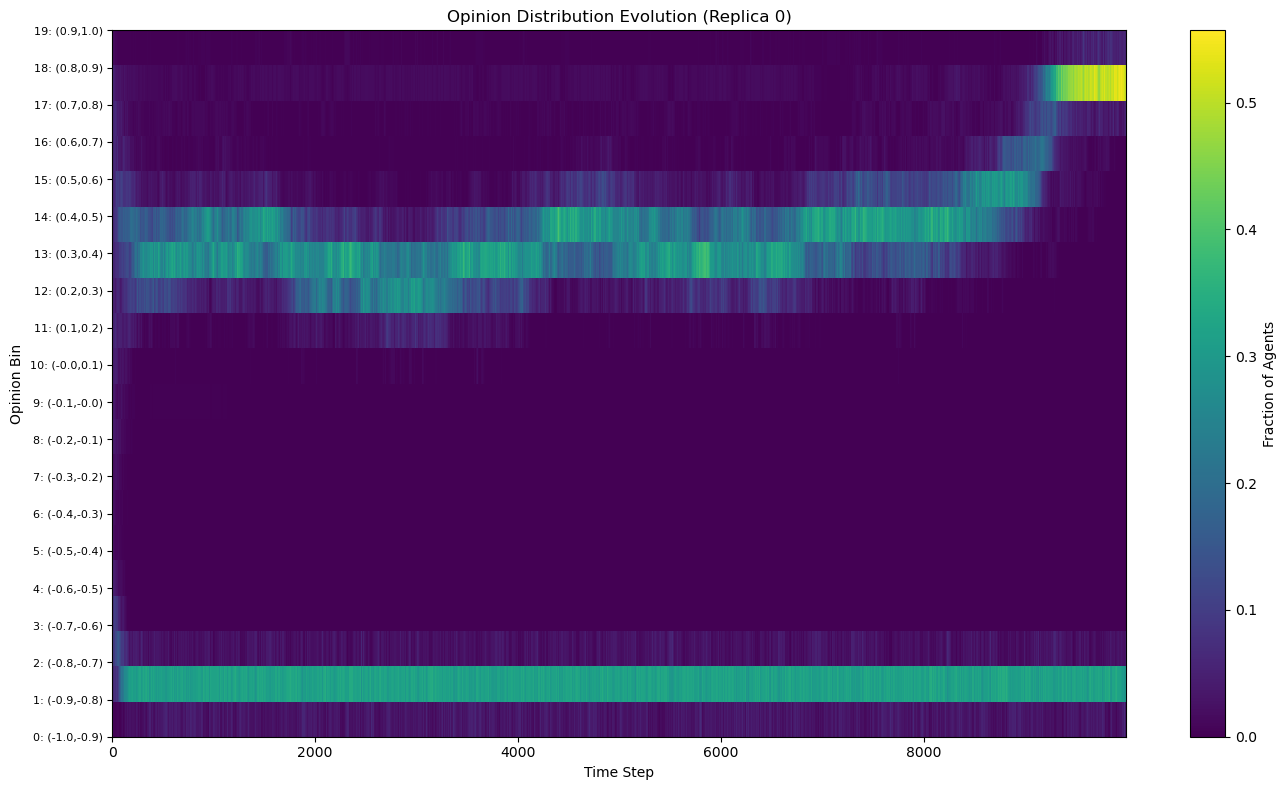

In [12]:
plot_opinion_distribution_evolution(RES, replica_idx=0)  # Specific replica

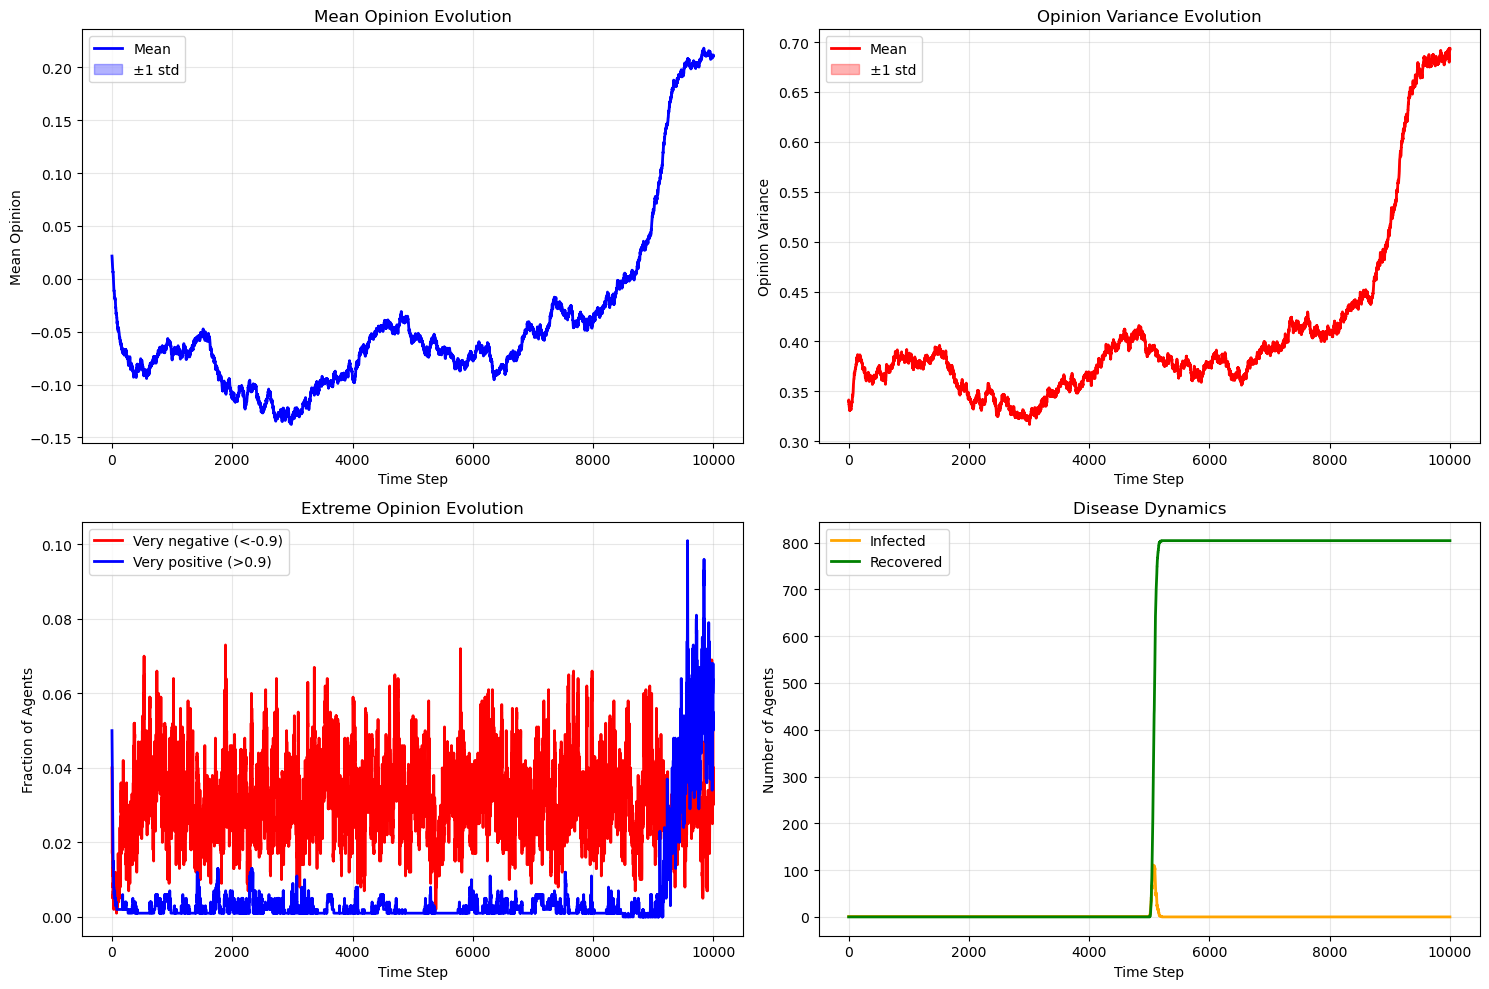

In [14]:
plot_aggregate_statistics(RES)

In [9]:
print(type(RES))
print(RES.keys() if hasattr(RES, 'keys') else 'Not a dict')

<class 'dict'>
dict_keys(['parameters', 'n_replicas', 'trajectory_replica_indices', 'S_count', 'I_count', 'R_count', 'mean_opinion', 'opinion_var', 'fraction_ever_infected', 'opinion_bins', 'opinions', 'save_steps', 'bin_edges', 'bin_labels'])


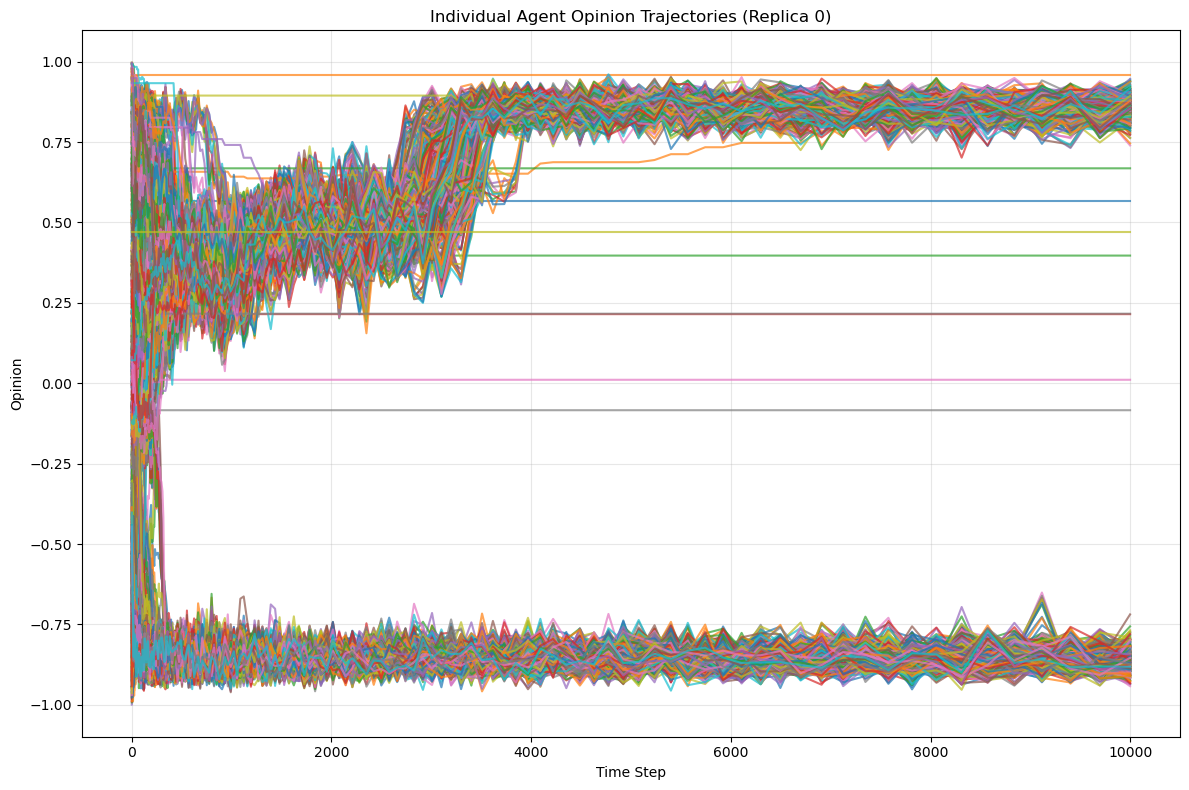

AttributeError: 'str' object has no attribute 'clabel'

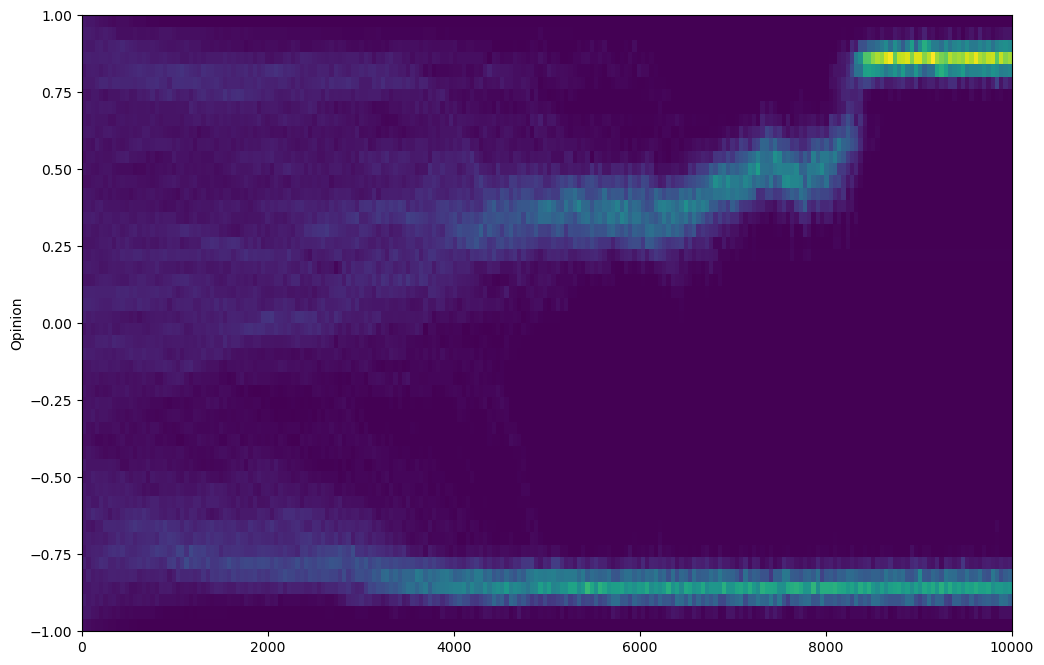

In [53]:
plot_agent_opinions(RES)
plot_binned_opinion_heatmap(RES)

In [ ]:
save_steps = RES[0]['save_steps']  # Time points when opinions were saved
opinions = RES[0]['opinions']      # Shape: (n_time_points, n_humans)


plt.figure(figsize=(12, 8))

# Plot trajectories for first n_agents_to_plot agents
for agent_id in range(min(n_agents_to_plot, opinions.shape[1])):
    agent_opinions = opinions[:, agent_id]  # Opinion trajectory for this agent
    plt.plot(save_steps, agent_opinions, alpha=0.7, linewidth=1.5, 
            label=f'Agent {agent_id}' if n_agents_to_plot <= 10 else None)








In [10]:
save_results(RES, parameters, "only1.pkl")

Results from 1 replicas saved to results\only1.pkl


In [11]:
from pickle_profile import *

In [16]:
filepath = "results/only1.pkl"
profile_pickle_memory(filepath)
with open(filepath, 'rb') as f:
            data = pickle.load(f)
suggest_optimizations(data['all_results'][0])








Total file size: 1.01 MB

MEMORY BREAKDOWN:
all_results         :     1.01 MB
parameters          :     0.00 MB
Total in memory     :     1.01 MB

RESULTS BREAKDOWN   
------------------------------
Number of replicas: 1
Size per replica: 1.01 MB
Projected 100 replicas: 100.83 MB

Per-replica component sizes:
  step_to_idx         :      3.7 KB  dict
  save_steps          :      0.9 KB  (218,) int32
  opinions            :    851.6 KB  (218, 1000) float32
  S_count             :     19.5 KB  (10000,) int16
  I_count             :     19.5 KB  (10000,) int16
  R_count             :     19.5 KB  (10000,) int16
  mean_opinion        :     39.1 KB  (10000,) float32
  opinion_var         :     39.1 KB  (10000,) float32
  fraction_ever_infected:     39.1 KB  (10000,) float32

OPTIMIZATION SUGGESTIONS
----------------------------------------

Total potential savings per replica: 0.0 KB
Savings for 100 replicas: 0.0 MB


In [27]:
type(ts)

dict

In [28]:
print(ts)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 41: 39, 42: 40, 43: 41, 45: 42, 46: 43, 47: 44, 49: 45, 51: 46, 52: 47, 54: 48, 56: 49, 57: 50, 59: 51, 61: 52, 63: 53, 65: 54, 67: 55, 69: 56, 71: 57, 74: 58, 76: 59, 78: 60, 81: 61, 83: 62, 86: 63, 89: 64, 92: 65, 94: 66, 97: 67, 101: 68, 104: 69, 107: 70, 110: 71, 114: 72, 117: 73, 121: 74, 125: 75, 129: 76, 133: 77, 137: 78, 142: 79, 146: 80, 151: 81, 155: 82, 160: 83, 165: 84, 170: 85, 176: 86, 181: 87, 187: 88, 193: 89, 199: 90, 205: 91, 212: 92, 218: 93, 225: 94, 232: 95, 240: 96, 247: 97, 255: 98, 263: 99, 271: 100, 280: 101, 288: 102, 297: 103, 307: 104, 316: 105, 326: 106, 337: 107, 347: 108, 358: 109, 369: 110, 381: 111, 393: 112, 405: 113, 418: 114, 431: 115, 444: 116, 458: 117, 473: 11

ValueError: x and y must have same first dimension, but have shapes (1,) and (218, 1000)

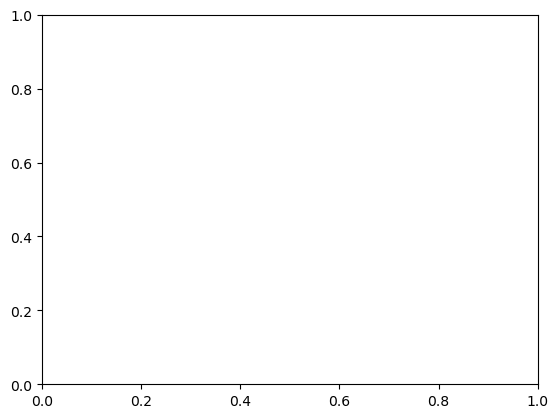

In [22]:
ts = RES[0]["step_to_idx"]
opt = RES[0]["opinions"]


plt.plot(ts, opt)












OPTIMIZATION SUGGESTIONS
----------------------------------------

Total potential savings per replica: 0.0 KB
Savings for 100 replicas: 0.0 MB
